<a href="https://colab.research.google.com/github/ekomissarov/data-analysis/blob/main/18_bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PART1 Coins years

In [51]:
#@title importing libraries
from scipy import stats
import statsmodels as sts

from google.colab import drive
import pandas as pd
import numpy as np
import time
from datetime import date, datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px


plt.style.use('dark_background')

def display_df(df=None):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df)

In [52]:
x = pd.Series([2011, 2017, 2016, 2012, 2017, 2015, 2011, 2015, 2017, 2012, 2019,
       2019, 2012, 2018, 2018, 2018, 2018, 2017, 2018, 2012, 2010, 2012,
       2012, 2011, 2011, 2012, 2011, 2017, 2017, 2016, 2012, 2012, 2017,
       2017, 2012, 2010, 2018, 2016, 2011, 2017, 2012, 2017, 2013, 2017,
       2010, 2011, 2018, 2015, 2011, 2018, 2012, 2013, 2009, 2017, 2017,
       2018, 2019, 2018, 2011, 2013, 2011, 2013, 2017, 2018, 2011, 2012,
       2018, 2012, 2019, 2018, 2011, 2017, 2019, 2019, 2019, 2012, 2011,
       2013, 2011, 2017, 2013, 2013, 2017, 2017, 2017, 2011, 2019, 2013,
       2017, 2012, 2009, 2010, 2010, 2020, 2019, 2020, 2020, 2019, 2018,
       2020])  # год выпуска монеты из копилки
x = x.max() - x # перешли к возрасту
x.size

100

In [53]:
x.values

array([ 9,  3,  4,  8,  3,  5,  9,  5,  3,  8,  1,  1,  8,  2,  2,  2,  2,
        3,  2,  8, 10,  8,  8,  9,  9,  8,  9,  3,  3,  4,  8,  8,  3,  3,
        8, 10,  2,  4,  9,  3,  8,  3,  7,  3, 10,  9,  2,  5,  9,  2,  8,
        7, 11,  3,  3,  2,  1,  2,  9,  7,  9,  7,  3,  2,  9,  8,  2,  8,
        1,  2,  9,  3,  1,  1,  1,  8,  9,  7,  9,  3,  7,  7,  3,  3,  3,
        9,  1,  7,  3,  8, 11, 10, 10,  0,  1,  0,  0,  1,  2,  0])

<Axes: ylabel='count'>

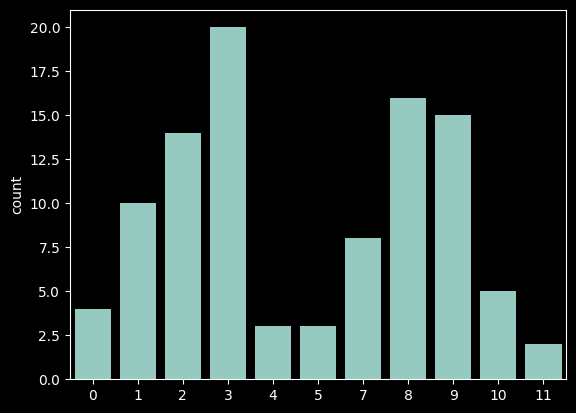

In [55]:
sns.countplot(x=x.values)

In [56]:
x.mean(), np.median(x)

(5.16, 4.0)

In [59]:
#построим доверительный интервал для среднего с помощью бутстрапа
def get_bootstrap_sample(x, B_sample=1, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed) # чтобы эксперимент воспроизводился
    N = x.size
    sample = np.random.choice(x, size=(N, B_sample), replace=True)

    if B_sample == 1:
        sample = sample.T[0]
    return sample

x_boot = get_bootstrap_sample(x)
x_boot.shape

(100,)

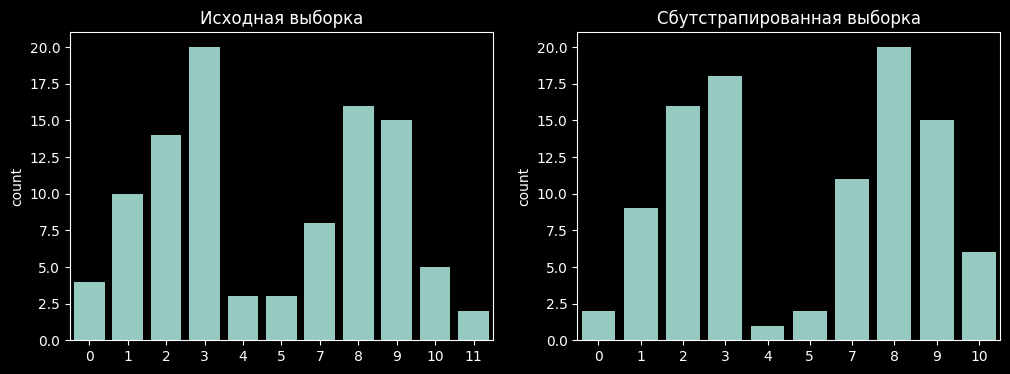

In [60]:
_, axes = plt.subplots(1, 2, figsize=(12,4))

sns.countplot(x=x.values, ax=axes[0])
sns.countplot(x=x_boot, ax=axes[1])
axes[0].set_title("Исходная выборка")
axes[1].set_title("Сбутстрапированная выборка");

In [61]:
#Сгенерируем выборку из средних
x_boot = get_bootstrap_sample(x, B_sample=10**6)
x_boot_m = np.mean(x_boot, axis=0)
x_boot_m.size

1000000

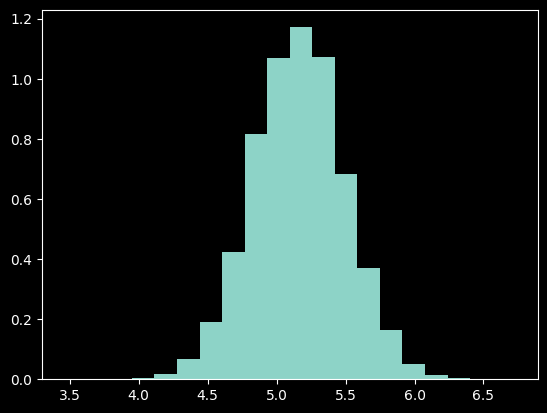

In [62]:
plt.hist(x_boot_m, bins=20, density=True);

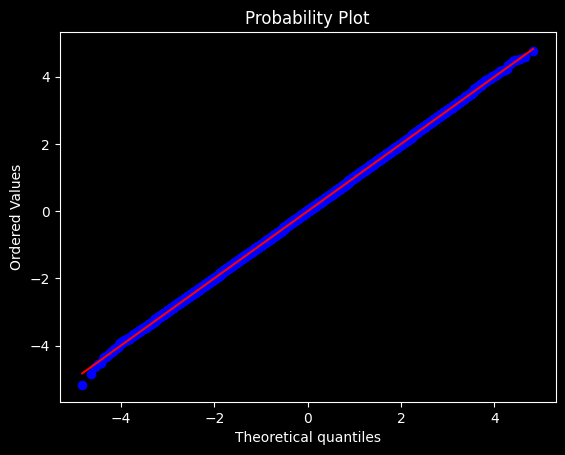

In [63]:
#Сравним получившееся распределение с нормальным. Они оказываются похожи.
#Это связано с тем, что мы бустрапируем среднее, в возрасте монет нет выбросов, поэтому тут хорошо работает ЦПТ.
#строим диаграмму: квантиль-квантиль
#диаграмма говорит о том что итоговое распределение получилось близким к нормальному
#и здесь для среднего мы на самом деле могли использовать ЦПТ

x_scale = (x_boot_m - x_boot_m.mean())/x_boot_m.std()
stats.probplot(x_scale, dist="norm", plot=plt);

In [65]:
#доверительный интервал Эфрона.
alpha = 0.05

left = np.quantile(x_boot_m, alpha/2)
right = np.quantile(x_boot_m, 1-alpha/2)
left, right


(4.52, 5.81)

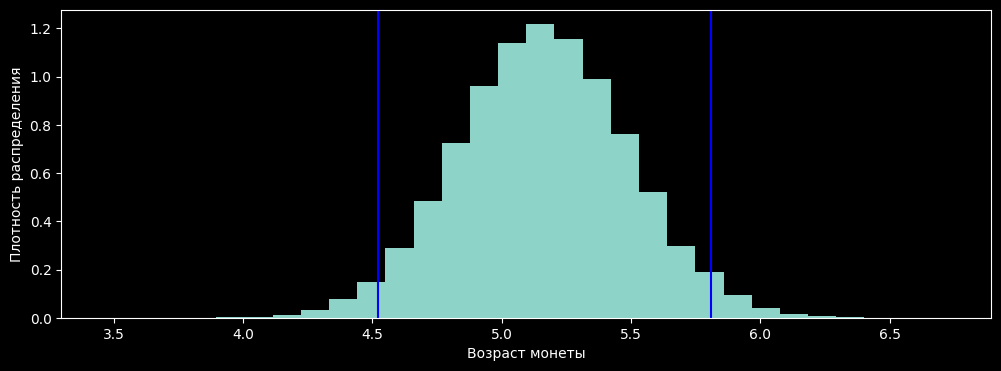

In [66]:
fig = plt.figure(figsize=(12,4))
plt.hist(x_boot_m, bins=30, density=True)
plt.axvline(left, color='b')
plt.axvline(right, color='b');

plt.xlabel('Возраст монеты')
plt.ylabel('Плотность распределения');

In [67]:
#доверительный интервал Холла
alpha = 0.05

theta_hat = np.mean(x)
x_boot_h = x_boot_m - theta_hat  # np.mean(x_boot - theta_hat, axis=0)

left = theta_hat - np.quantile(x_boot_h, 1-alpha/2)
right = theta_hat - np.quantile(x_boot_h, alpha/2)
left, right



(4.510000000000001, 5.800000000000001)

In [68]:
#t-процентильный доверительный интервал
theta_hat = np.mean(x)
std_hat = np.std(x)

x_boot_t = np.mean(x_boot - theta_hat, axis=0)
x_boot_t = x_boot_t/np.std(x_boot, axis=0)

left = theta_hat - np.quantile(x_boot_t, 1-alpha/2)*std_hat
right = theta_hat - np.quantile(x_boot_t, alpha/2)*std_hat
left, right



(4.50760608395731, 5.820627340161765)

In [69]:
#цпт
lam_hat = np.mean(x)  # sample parameter estimation
lam_se = np.sqrt(lam_hat/len(x))  # standard deviation estimation

stats.norm.interval(0.95, loc=lam_hat, scale=lam_se)


(4.714781766829101, 5.605218233170899)

#PART2 Medians difference Efron

In [70]:
#@title mounting Google drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [71]:
#@title reading original csv
df = pd.read_csv('gdrive/MyDrive/public_data/df_vk_wise.csv', sep=',')
df.head()

,likes,reposts,text,I
0,7,0,Кому удобнее следить за новостями М. в инстагр...,False
1,575,25,"Если девушка невероятно хороша в юности, но ра...",False
2,509,57,"То была очень обычная узость мышления - те, кт...",False
3,542,15,"Когда он знакомил меня с Сергеем, тот спросил:...",False
4,949,59,"- Общепризнано, сэр, что физические упражнения...",False


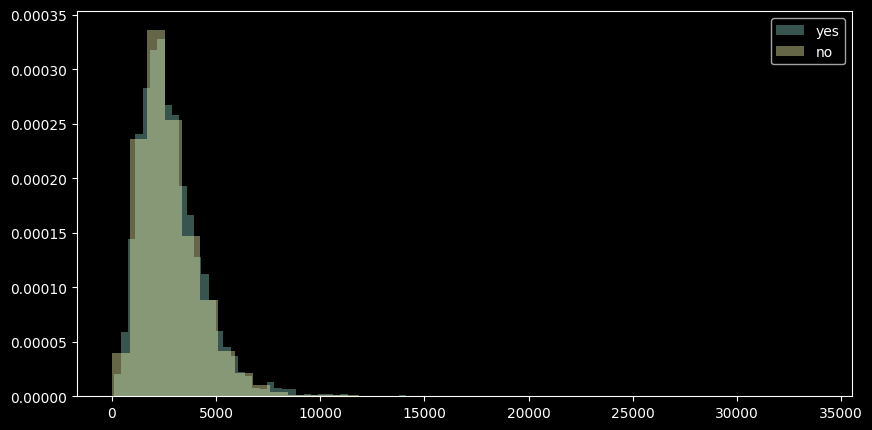

In [72]:
#Построим гистограмму для числа репостов постов, содержащих личные местоимения и не содержащих
x = df[df['I']== True]['likes'].values
y = df[df['I']== False]['likes'].values

plt.figure(figsize=(10,5))
plt.hist(x, bins=40, density=True, alpha=0.4, label='yes')
plt.hist(y, bins=40, density=True, alpha=0.4, label='no')
plt.legend();

In [48]:
np.median(x), np.median(y)

(2580.5, 2490.0)

In [73]:
# Хвосты на гистограммах оказываются очень длинными. У нас есть выбросы.
# Смотреть на средние, чтобы сравнить между собой разные цитаты, будет некорректно.
# Будем смотреть на медианы. Построим доверительный интервал для разности медиан.
x_boot = get_bootstrap_sample(x, B_sample=10**4, random_seed=42)
x_boot = np.median(x_boot, axis=0)

y_boot = get_bootstrap_sample(y, B_sample=10**4, random_seed=42)
y_boot = np.median(y_boot, axis=0)

In [74]:
def efron_intervals(boot, alpha=0.05):
    left = np.quantile(boot, alpha/2)
    right = np.quantile(boot, 1-alpha/2)
    return left, right

In [75]:
print(efron_intervals(x_boot))
print(efron_intervals(y_boot))

(2516.0, 2659.0)
(2456.0, 2528.0)


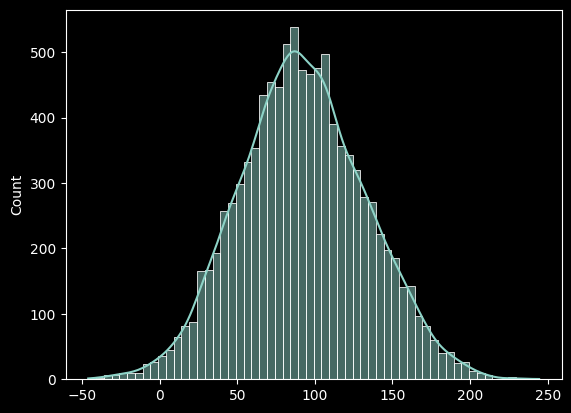

In [76]:
# Доверительные интервалы пересекаются. Но делать вывод лучше по доверительному интервалу для разности. Такая процедура будет мощнее
sns.histplot(x_boot - y_boot, kde=True);

In [77]:
print("Доверительный интервал Эфрона для разницы медиан:", efron_intervals(x_boot - y_boot))

Доверительный интервал Эфрона для разницы медиан: (14.987500000000011, 172.51249999999982)


In [78]:
#Ноль не попадает в доверительный интервал, значит на уровне значимости разница есть. На последок посмотрим на вероятность того, что разность больше нуля.
np.mean(x_boot - y_boot > 0)

0.9902

#PART3 Median difference Hall

In [79]:
theta_hat_x = np.median(x)
theta_hat_y = np.median(y)

print(theta_hat_x - theta_hat_y)
print(np.median(x - theta_hat_y))

90.5
90.5


In [88]:
def hall_intervals(boot, theta_hat, alpha=0.05):
    boot_h = boot - theta_hat

    left = theta_hat - np.quantile(boot_h, 1-alpha/2)
    right = theta_hat - np.quantile(boot_h, alpha/2)
    return left, right


print(hall_intervals(x_boot, theta_hat_x))
print(hall_intervals(y_boot, theta_hat_y))
print(hall_intervals(x_boot - y_boot, theta_hat = np.median(x - theta_hat_y)))


(2502.0, 2645.0)
(2452.0, 2524.0)
(8.487500000000182, 166.0125)


In [90]:
# https://habr.com/ru/articles/829336/
def get_bootstrap_ci(X, func, B_sample = 10**4, kind = 't-percentile', alpha = 0.05, random_seed=None):
    n = X.size
    bootstrap_samples = get_bootstrap_sample(X, B_sample=B_sample, random_seed=42)
    theta_hat_star = func(bootstrap_samples, axis=0)


    if kind == 't-percentile':
        theta_hat = func(X)
        se_theta_hat = np.std(X, ddof=1) / np.sqrt(n)
        se_theta_hat_star = np.std(bootstrap_samples, axis=1, ddof=1) / np.sqrt(n)
        theta_hat_star = (theta_hat_star - theta_hat) / se_theta_hat_star
        left, right = np.quantile(theta_hat_star, (1 - alpha / 2, alpha / 2))
        ci = (theta_hat - se_theta_hat * left, theta_hat - se_theta_hat * right)

    elif kind == 'Hall':
        theta_hat = func(X)
        theta_hat_star -= theta_hat
        left, right = np.quantile(theta_hat_star, (1 - alpha / 2, alpha / 2))
        ci = (theta_hat - left, theta_hat - right)

    elif kind == 'Efron':
        left, right = np.quantile(theta_hat_star, (alpha / 2, 1 - alpha / 2))
        ci = (left, right)

    else:
        raise ValueError('Unknown method')

    return ci

print(get_bootstrap_ci(x, np.median, kind='Hall', random_seed=42))


(2502.0, 2645.0)


Обычно бутстрап применяется в следующих случаях:
*  теоретическое распределение данных неизвестно;
*  объем выборки мал для прямой статистической оценки;
*  нет параметрических или непараметрических аналогов;
*  необходима оценка сложных статистик, для которых сложно получить аналитические формулы.


Ключевое преимущество бутстрапа заключается в том, что его можно применять в широком спектре задач, даже тогда, когда все остальные методы, как параметрические, так и непараметрические, бессильны.


Данный метод не требует предположений о распределении данных от исследователя. Единственное условие, которое необходимо выполнить — репрезентативность выборки.



Проблемы

1) По сравнению с аналитическими доверительными интервалами, доверительные интервалы, полученные с помощью бутстрапирования (не имеет значения какая выбрана схема), несколько уже, если исходная выборка мала. Это является недостатком, так как мы по сути недооцениваем разброс выборочной статистики при небольшом количестве наблюдений в исходной выборке.


2) С помощью бутстрапирования мы охватываем асимптотически только 63% наблюдений из исходной выборки, а 37% наблюдений не попадают в бутстрап-выборку. Этот факт является следствием того, что мы берем выборки с повторениями.


3) Исходя из предыдущего факта следует, что бутстрап является отличной техникой для работы в средиземье, но не в крайнеземье. А когда у распределения исходной выборки тяжелые хвосты (то есть много выбросов), бутстрап может начать плохо себя показывать даже в средиземье.


4) При наличии структуры в данных (регрессия, временные ряды) бутстрап схему необходимо устроить таким образом, чтобы она учитывала эту структуру.
